# Gráficos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Set2")


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import SplineTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

from tensorflow import compat
compat.v1.logging.set_verbosity(compat.v1.logging.ERROR)

In [2]:
import itertools

In [3]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE?'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}


In [4]:
# classifica o input de acordo com a categoria 
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [6]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

In [8]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)

In [9]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

In [10]:
# mostra os deltas percentuais 
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(30,10))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()
    
    return error

In [11]:
def get_regiao (x):
    return REGIOES[x]

In [12]:
# separa y_test e y_pred em dados por estado e ao longo do tempo
def get_pred (y_test, y_pred):
    
    # os testes sao realizados com dados de 07/2017 ate 12/2019
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    # todas as datas se repetem para cada estado
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    # todos os estados se repetem para cada data
    pred['estados'] = SIGLAS * 30
    
    # garante que todos os estados estao presentes em todas as datas 
    pred['y_test'] =  y_test[len(y_test) % 27 :]
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(get_regiao)
    
    return pred

# Old

In [48]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(GRU(units=64, activation="relu"))),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 31097.947827964806
MAE: 16189.631996734914
MAPE: 0.12022037024887686
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 38248.23270872343
MAE: 22117.504834280302
MAPE: 0.18114744501924276


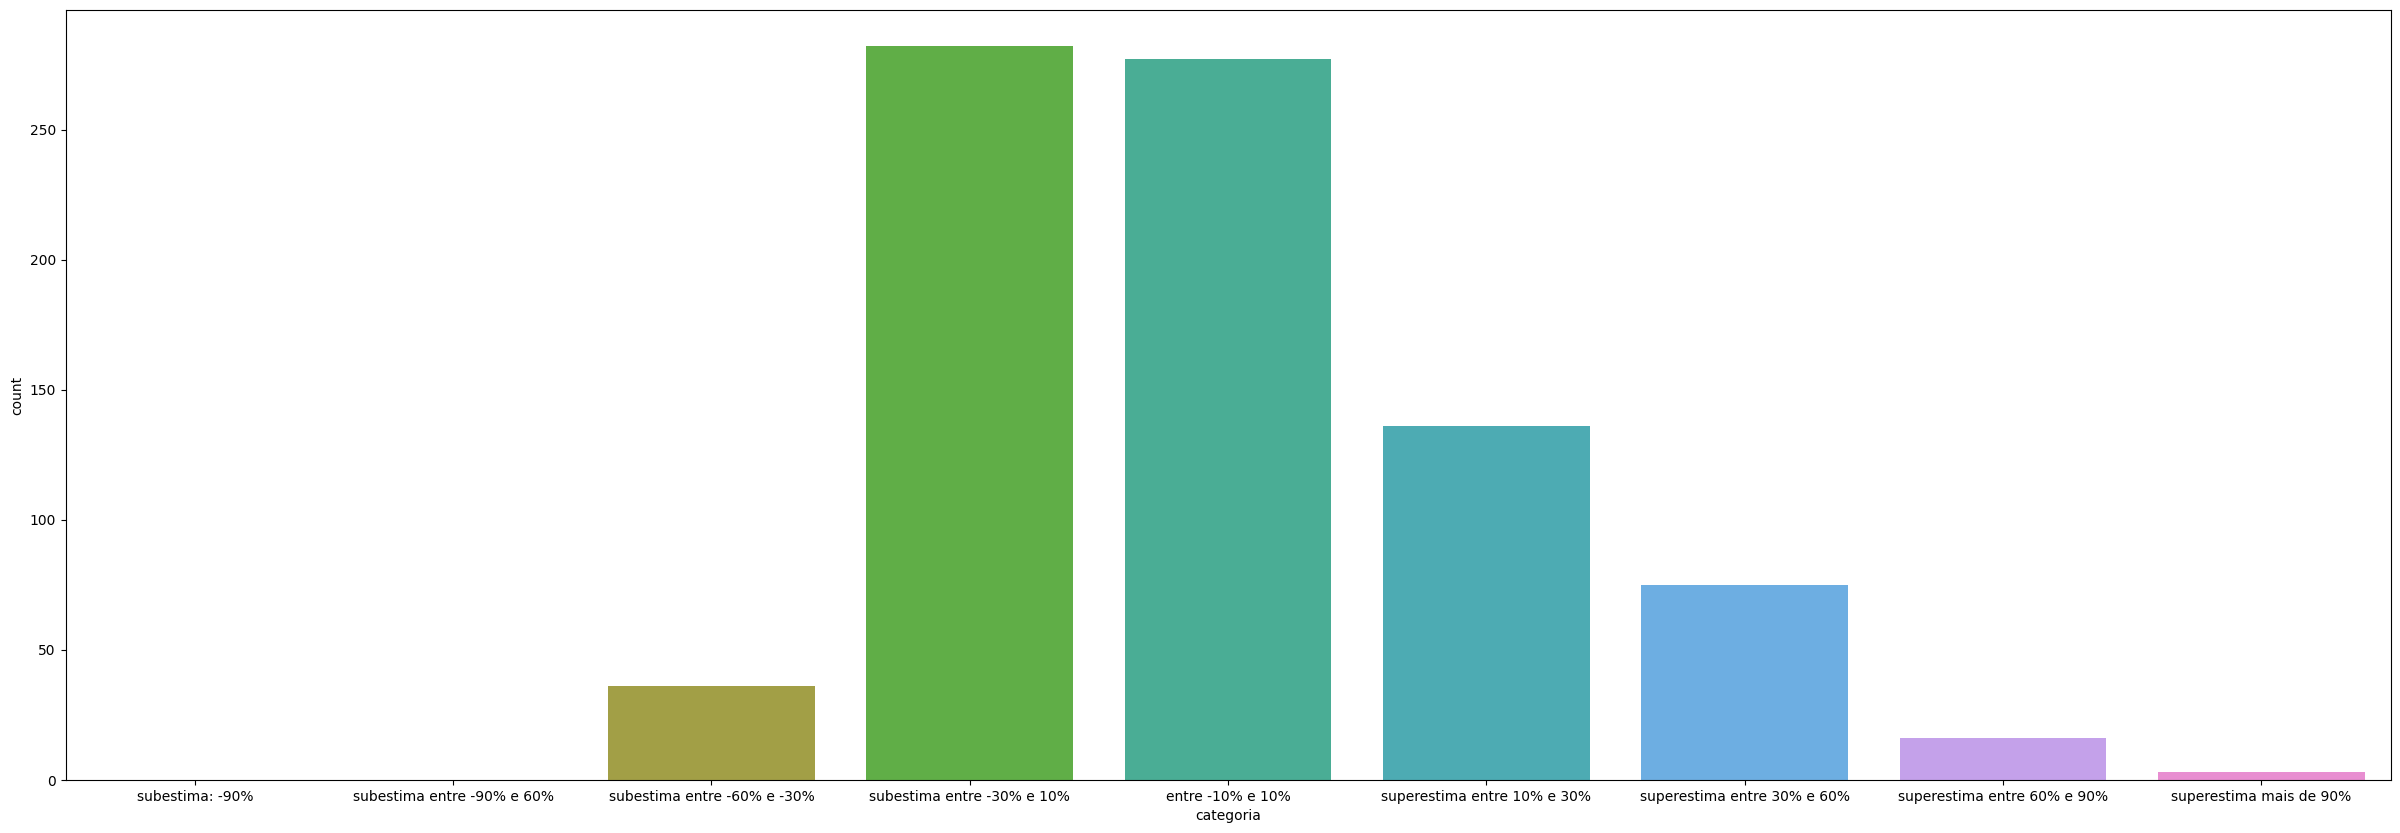

In [49]:
err = show_delta(np.array(y_test), y_pred.flatten())

In [50]:
err['categoria'].value_counts()

subestima entre -30% e 10%     282
entre -10% e 10%               277
superestima entre 10% e 30%    136
superestima entre 30% e 60%     75
subestima entre -60% e -30%     36
superestima entre 60% e 90%     16
superestima mais de 90%          3
Name: categoria, dtype: int64

In [51]:
pred=get_pred(y_test, y_pred)
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data') 

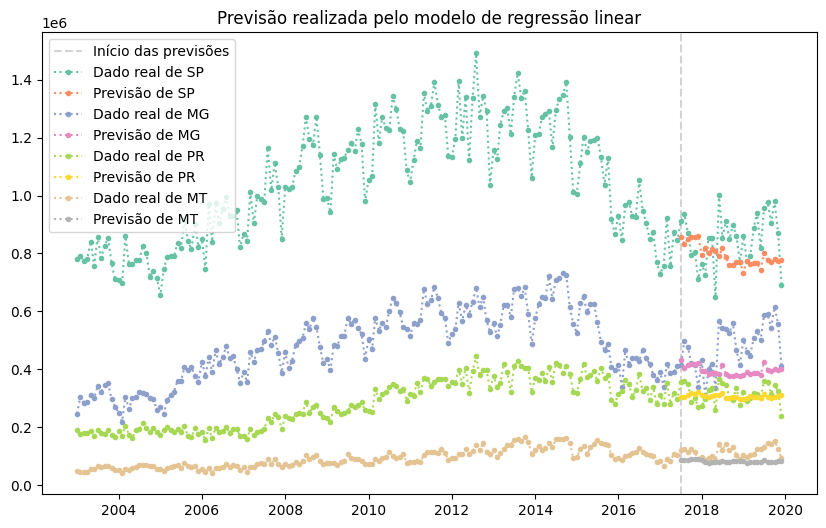

In [52]:
sns.set_palette("Set2")

plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

ind = 0

for s in ["SP","MG", "PR", 'MT']:
    
    plt.plot(resultados[resultados['estados'] == s]['dado real'], label=f"Dado real de {s}", linestyle=":", marker=".")
    ind += 1
    plt.plot(resultados[resultados['estados'] == s]['previsão'],label=f"Previsão de {s}",  linestyle=":", marker=".")

plt.legend()

plt.show()

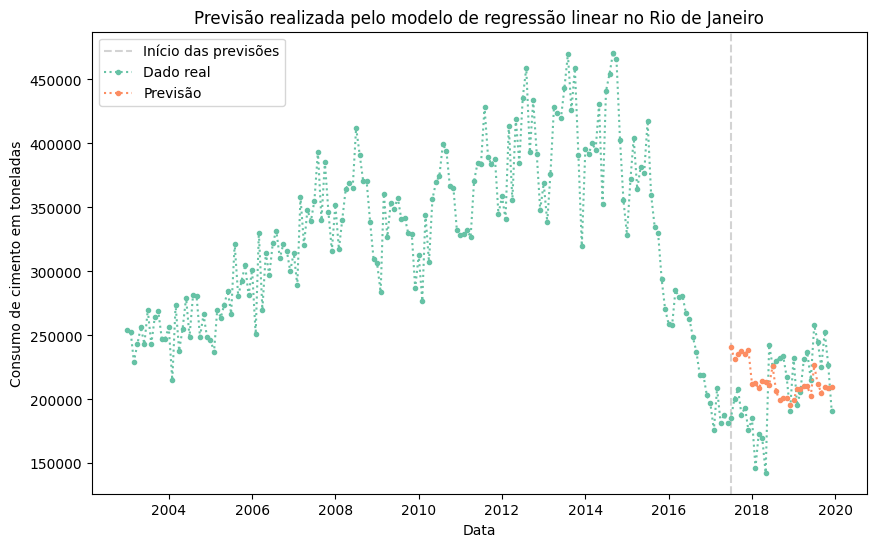

In [22]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Rio de Janeiro")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "RJ"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "RJ"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

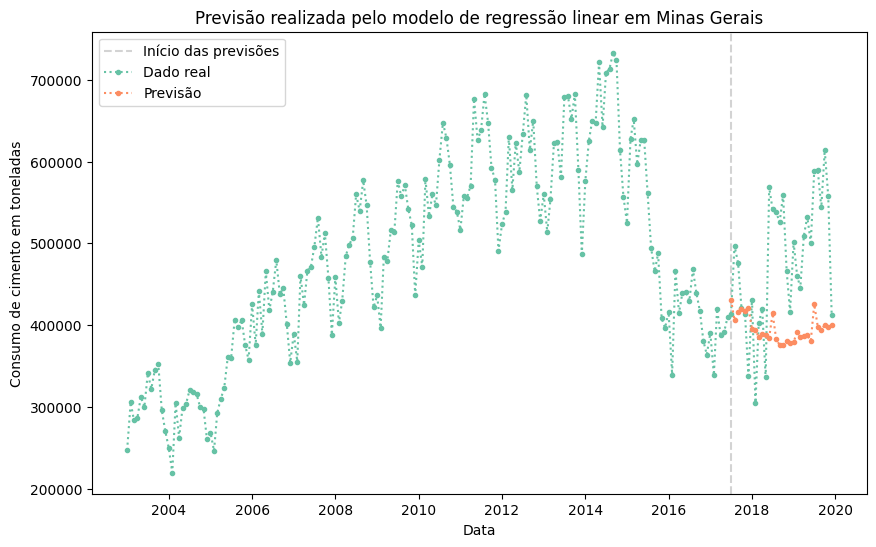

In [23]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em Minas Gerais")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "MG"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "MG"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

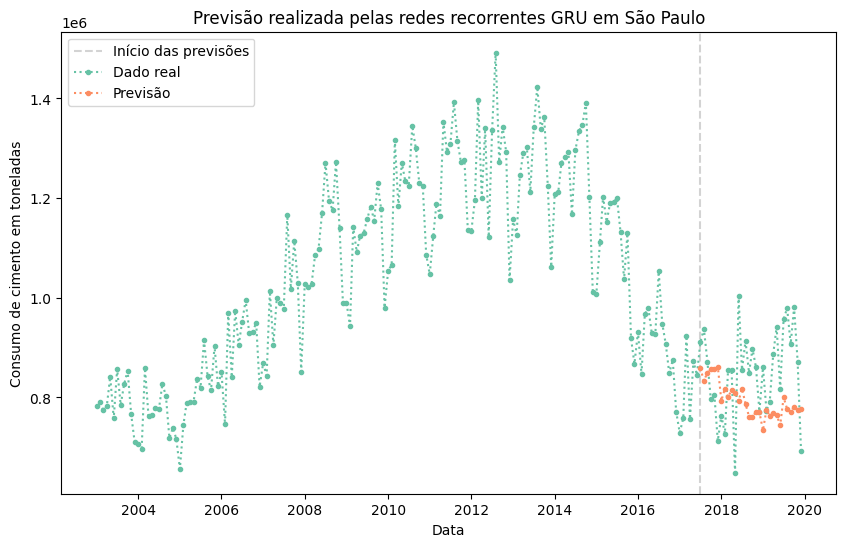

In [25]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelas redes recorrentes GRU em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

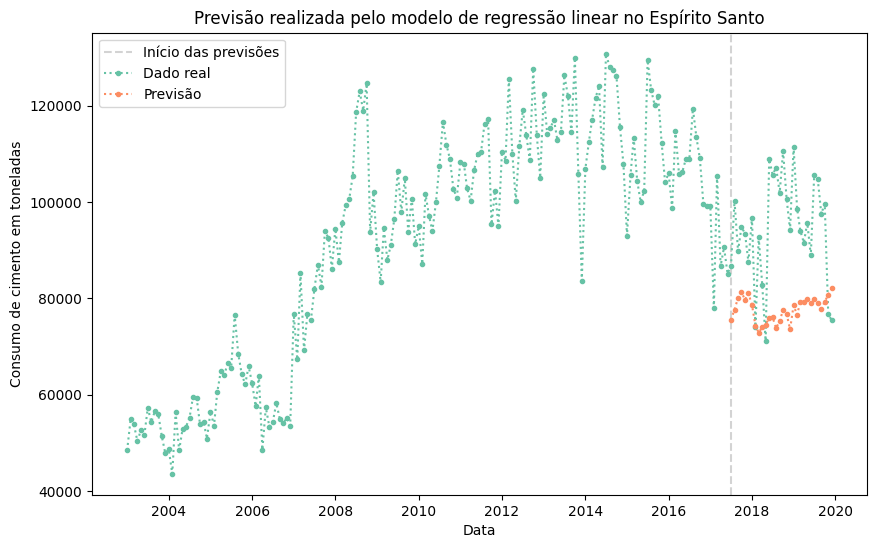

In [28]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Espírito Santo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "ES"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "ES"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

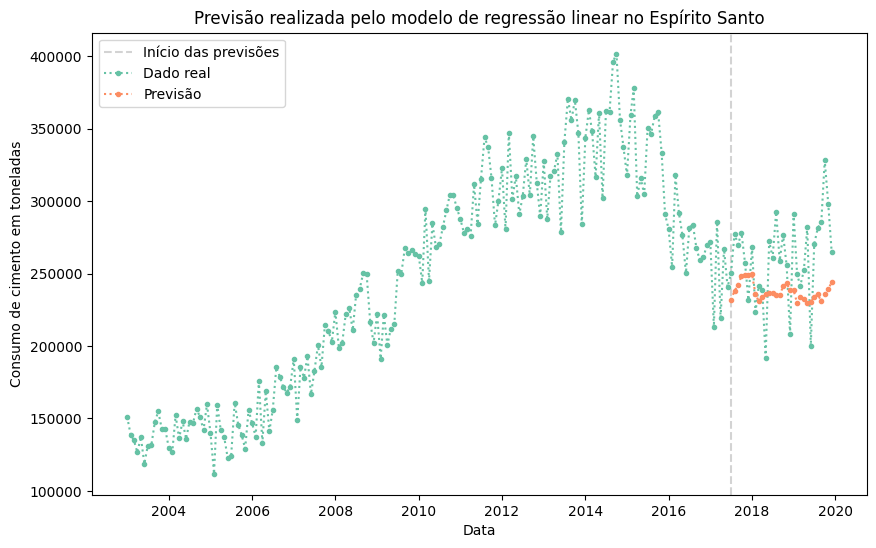

In [33]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Espírito Santo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "BA"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "BA"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

# Linear regression

In [59]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'nfsp','preco_saco', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9525886520535334
Scores obtidos:
RMSE: 38970.65917062515
MAE: 26435.65453576784
MAPE: 0.3237008399620483


In [61]:
pred=get_pred(y_test, y_pred)
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data')

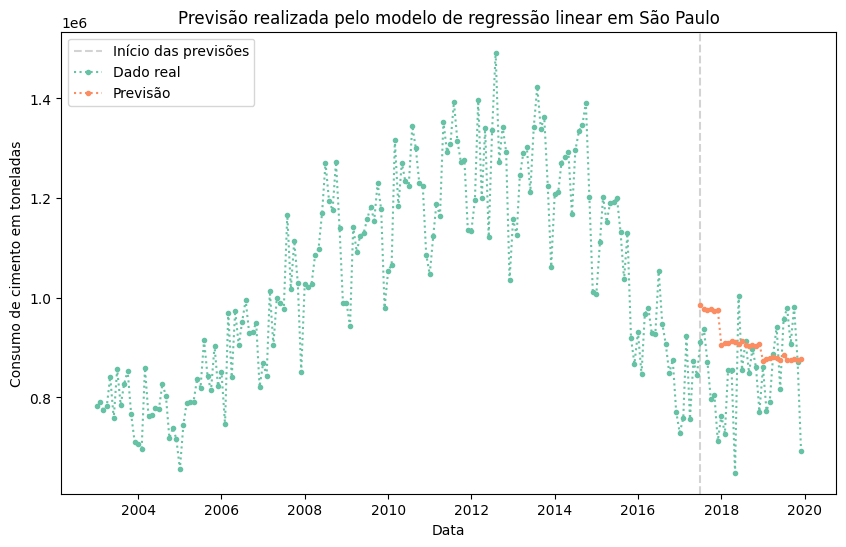

In [62]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


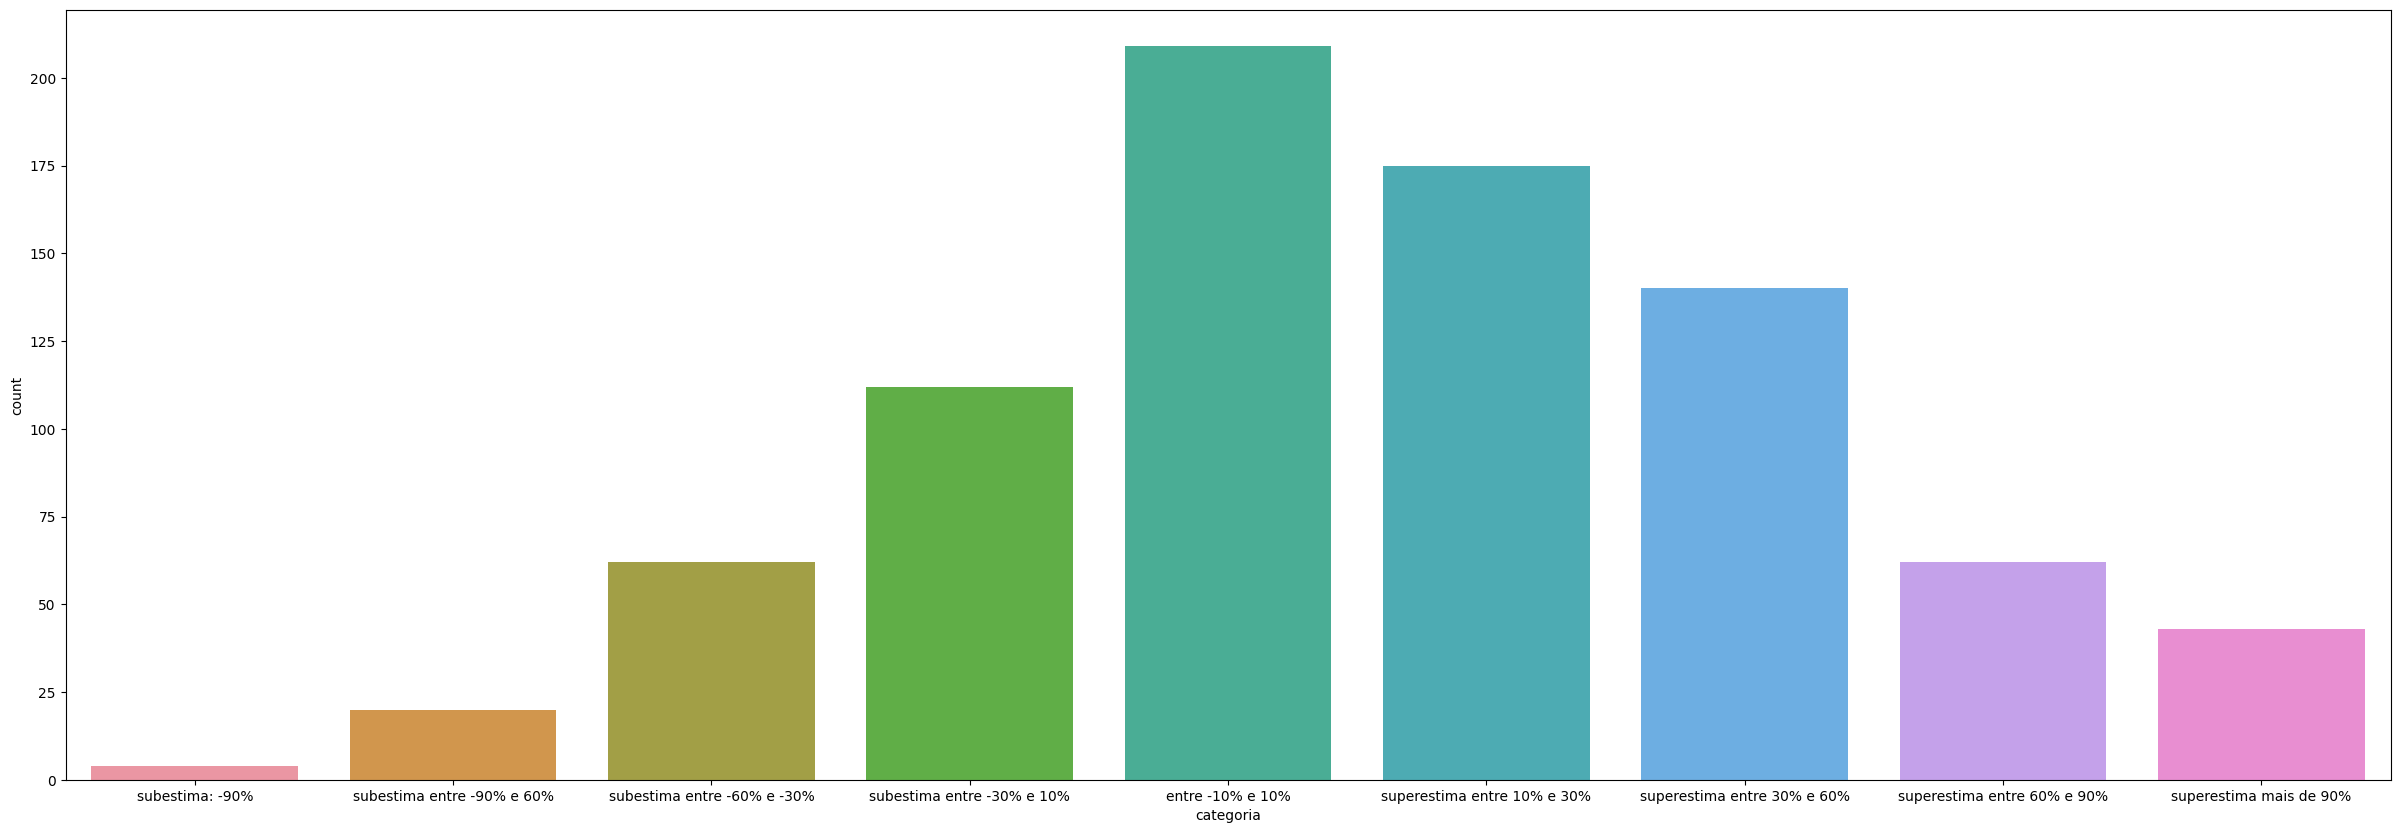

In [69]:
err = show_delta(np.array(y_test), y_pred.flatten())

In [71]:
err.to_csv("../experimentos/erro-rg.csv", index=False)

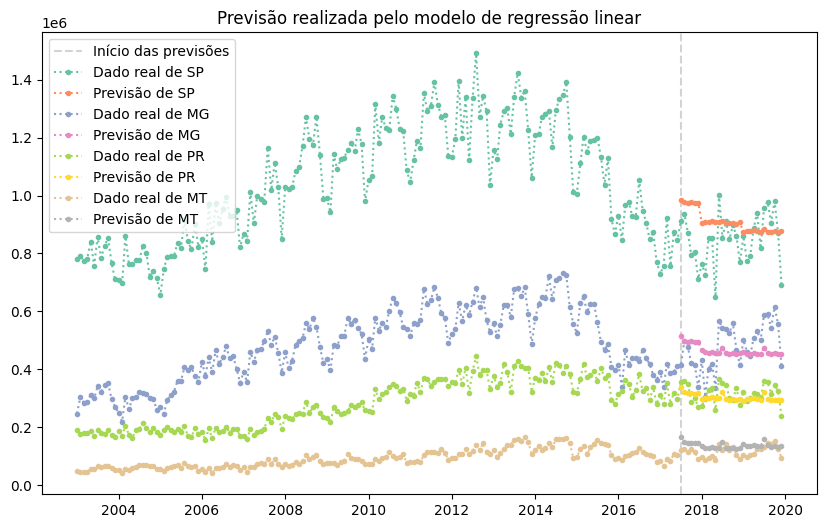

In [47]:
sns.set_palette("Set2")

plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

ind = 0

for s in ["SP","MG", "PR", 'MT']:
    
    plt.plot(resultados[resultados['estados'] == s]['dado real'], label=f"Dado real de {s}", linestyle=":", marker=".")
    ind += 1
    plt.plot(resultados[resultados['estados'] == s]['previsão'],label=f"Previsão de {s}",  linestyle=":", marker=".")

plt.legend()

plt.show()

# [old] Redes *feed forward*


In [15]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

mlp = Sequential()
mlp.add(Dense(units=256, activation="swish")),
mlp.add(Dense(units=128, activation="swish")),
mlp.add(Dense(units=64, activation="swish")),
mlp.add(Dense(units=32, activation="swish")),
mlp.add(Dropout(rate=0.10))
mlp.add(Dense(units=1))
mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=mlp.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, mlp.predict(x_train)))

y_pred_mlp = mlp.predict(x_test)
scores = score_regression_metrics(y_test, y_pred_mlp)
show_scores(scores)

147/147 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 24662.462205780543
MAE: 14255.874019494533
MAPE: 0.15902319609908813
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 40111.72122615334
MAE: 23781.75262620919
MAPE: 0.23878239249925137


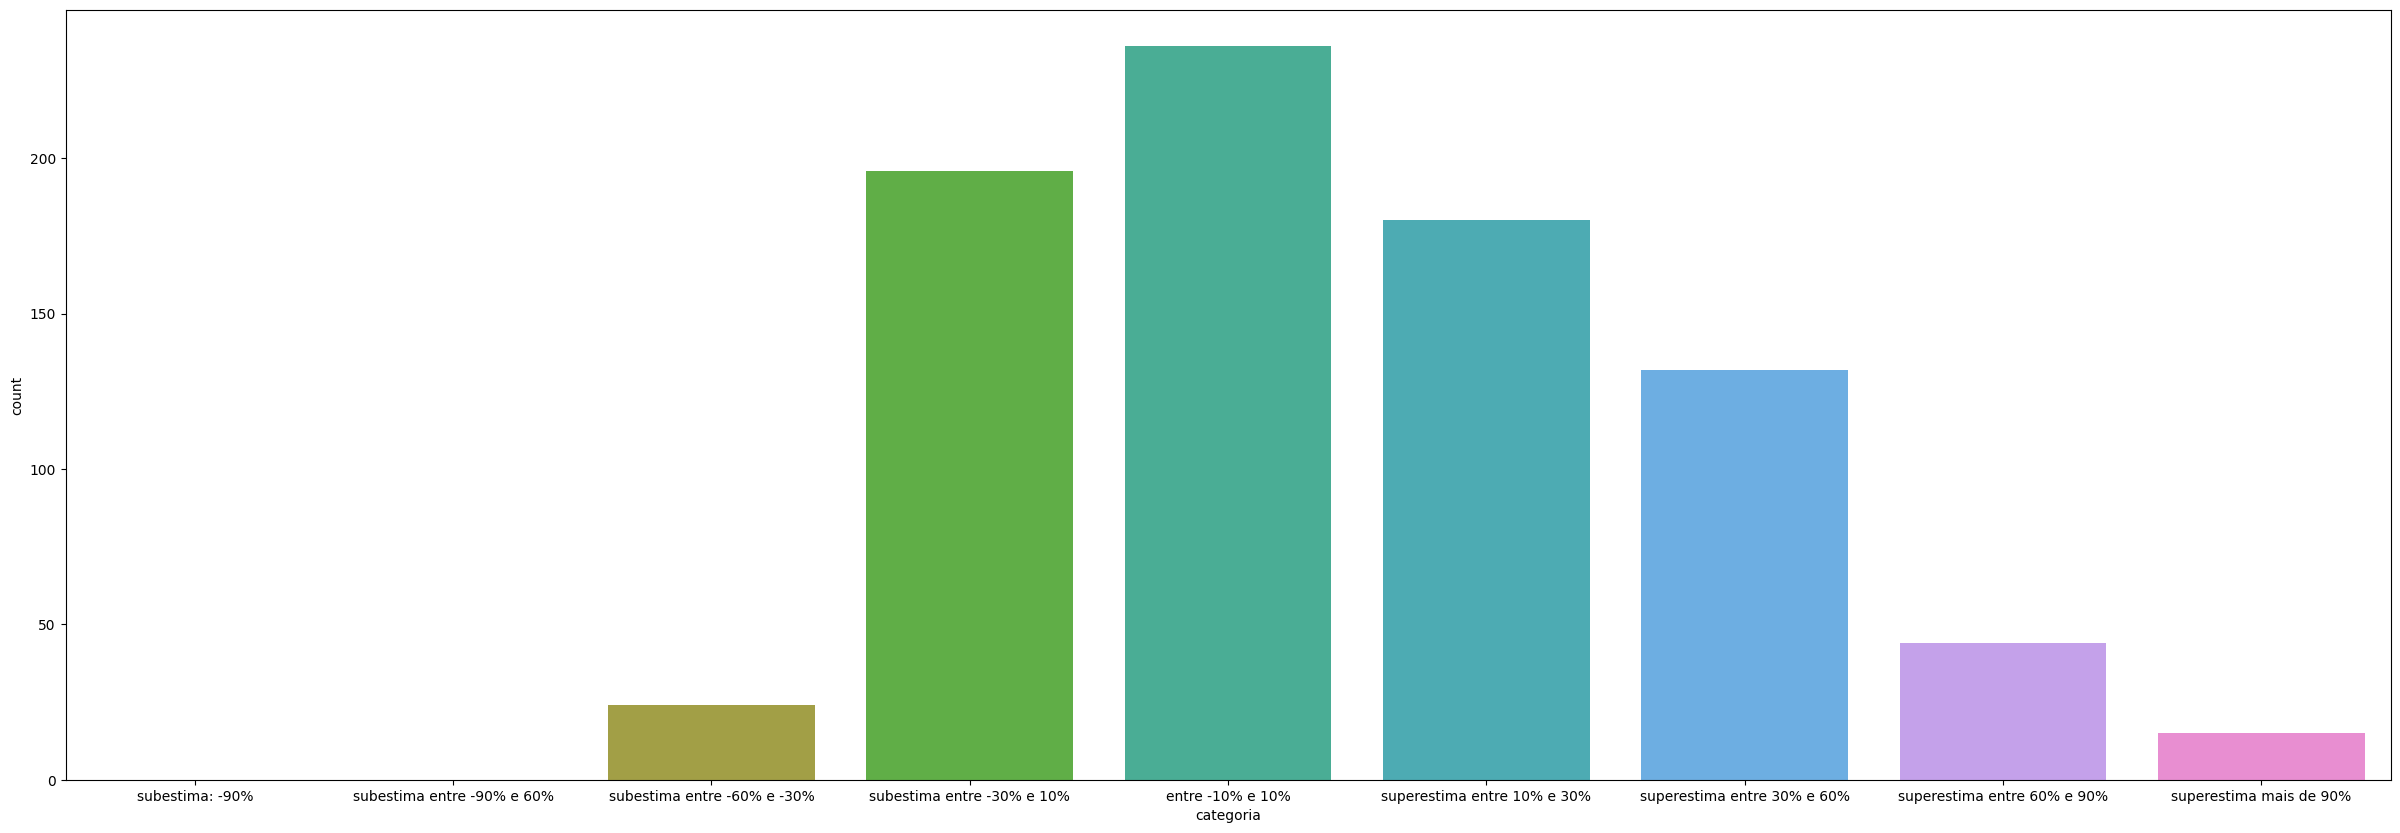

In [27]:
err = show_delta(np.array(y_test), y_pred.flatten())

In [28]:
pred=get_pred(y_test, y_pred)

df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])

df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data')

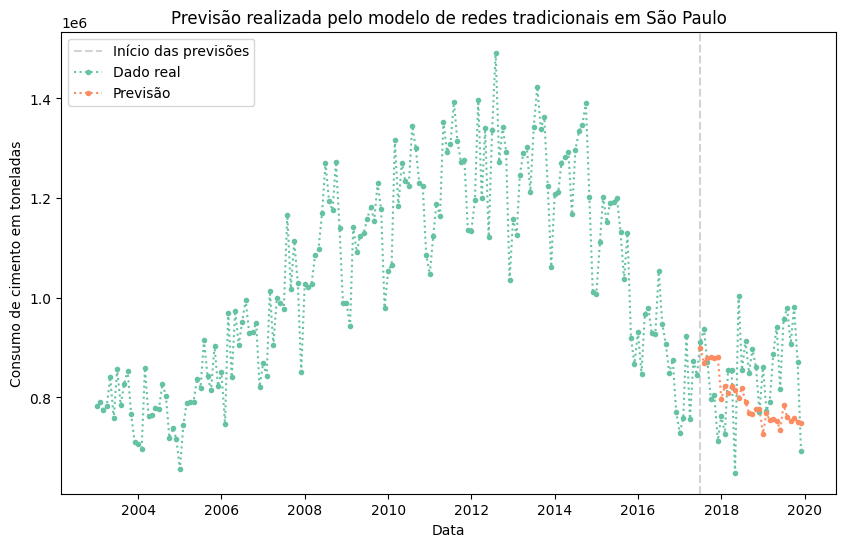

In [29]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de redes tradicionais em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


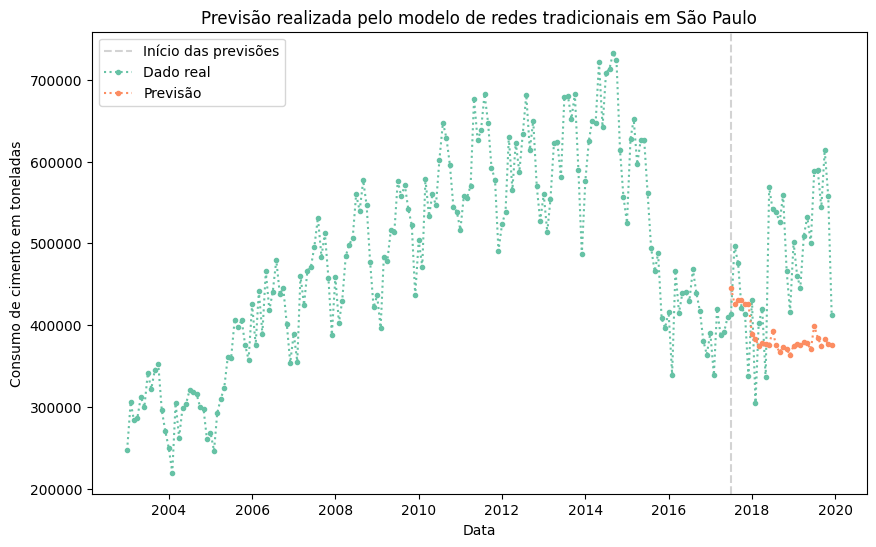

In [30]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de redes tradicionais em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "MG"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "MG"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

<AxesSubplot: xlabel='data'>

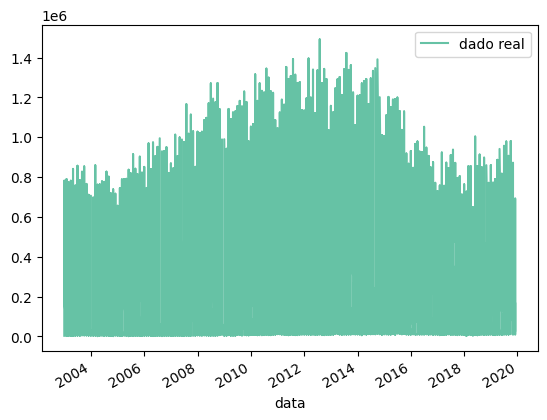

In [32]:
resultados[["dado real", "estados"]].plot()

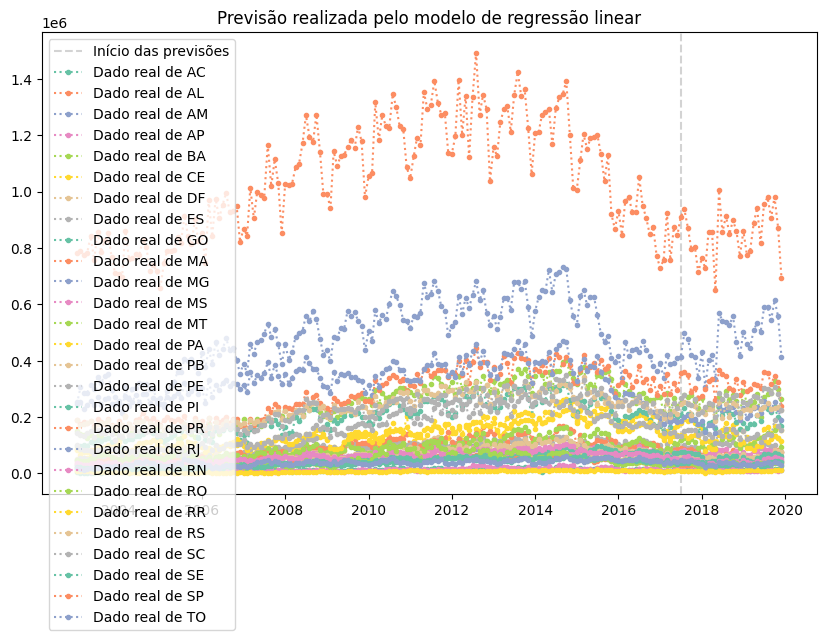

In [40]:
sns.set_palette("Set2")

plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

ind = 0

for s in resultados['estados'].unique():
    
    plt.plot(resultados[resultados['estados'] == s]['dado real'], label=f"Dado real de {s}", linestyle=":", marker=".")
    ind += 1

plt.legend()

plt.show()

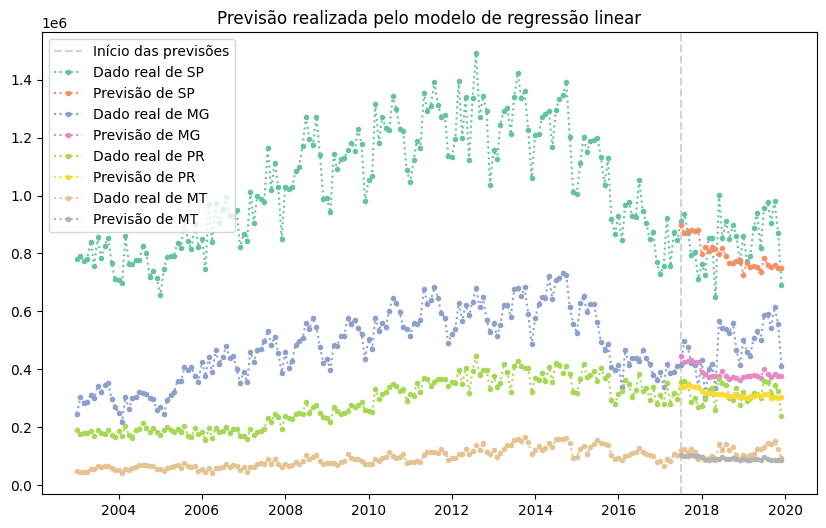

In [42]:
sns.set_palette("Set2")

plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

ind = 0

for s in ["SP","MG", "PR", 'MT']:
    
    plt.plot(resultados[resultados['estados'] == s]['dado real'], label=f"Dado real de {s}", linestyle=":", marker=".")
    ind += 1
    plt.plot(resultados[resultados['estados'] == s]['previsão'],label=f"Previsão de {s}",  linestyle=":", marker=".")

plt.legend()

plt.show()

# Redes *feed forward*

In [63]:
SEED = 41
set_seeds(SEED)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

mlp = Sequential()
mlp.add(Dense(units=256, activation="swish")),
mlp.add(Dense(units=128, activation="swish")),
mlp.add(Dense(units=32, activation= "swish")),
mlp.add(Dropout(rate=0.10))
mlp.add(Dense(units=1))
mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=mlp.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, mlp.predict(x_train)))

y_pred_mlp = mlp.predict(x_test)
scores = score_regression_metrics(y_test, y_pred_mlp)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 26115.10624794582
MAE: 14664.525058759096
MAPE: 0.15207547515654818
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 50830.11447018245
MAE: 26879.660465780165
MAPE: 0.26809156202920614


In [64]:
pred=get_pred(y_test, y_pred_mlp)
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data')

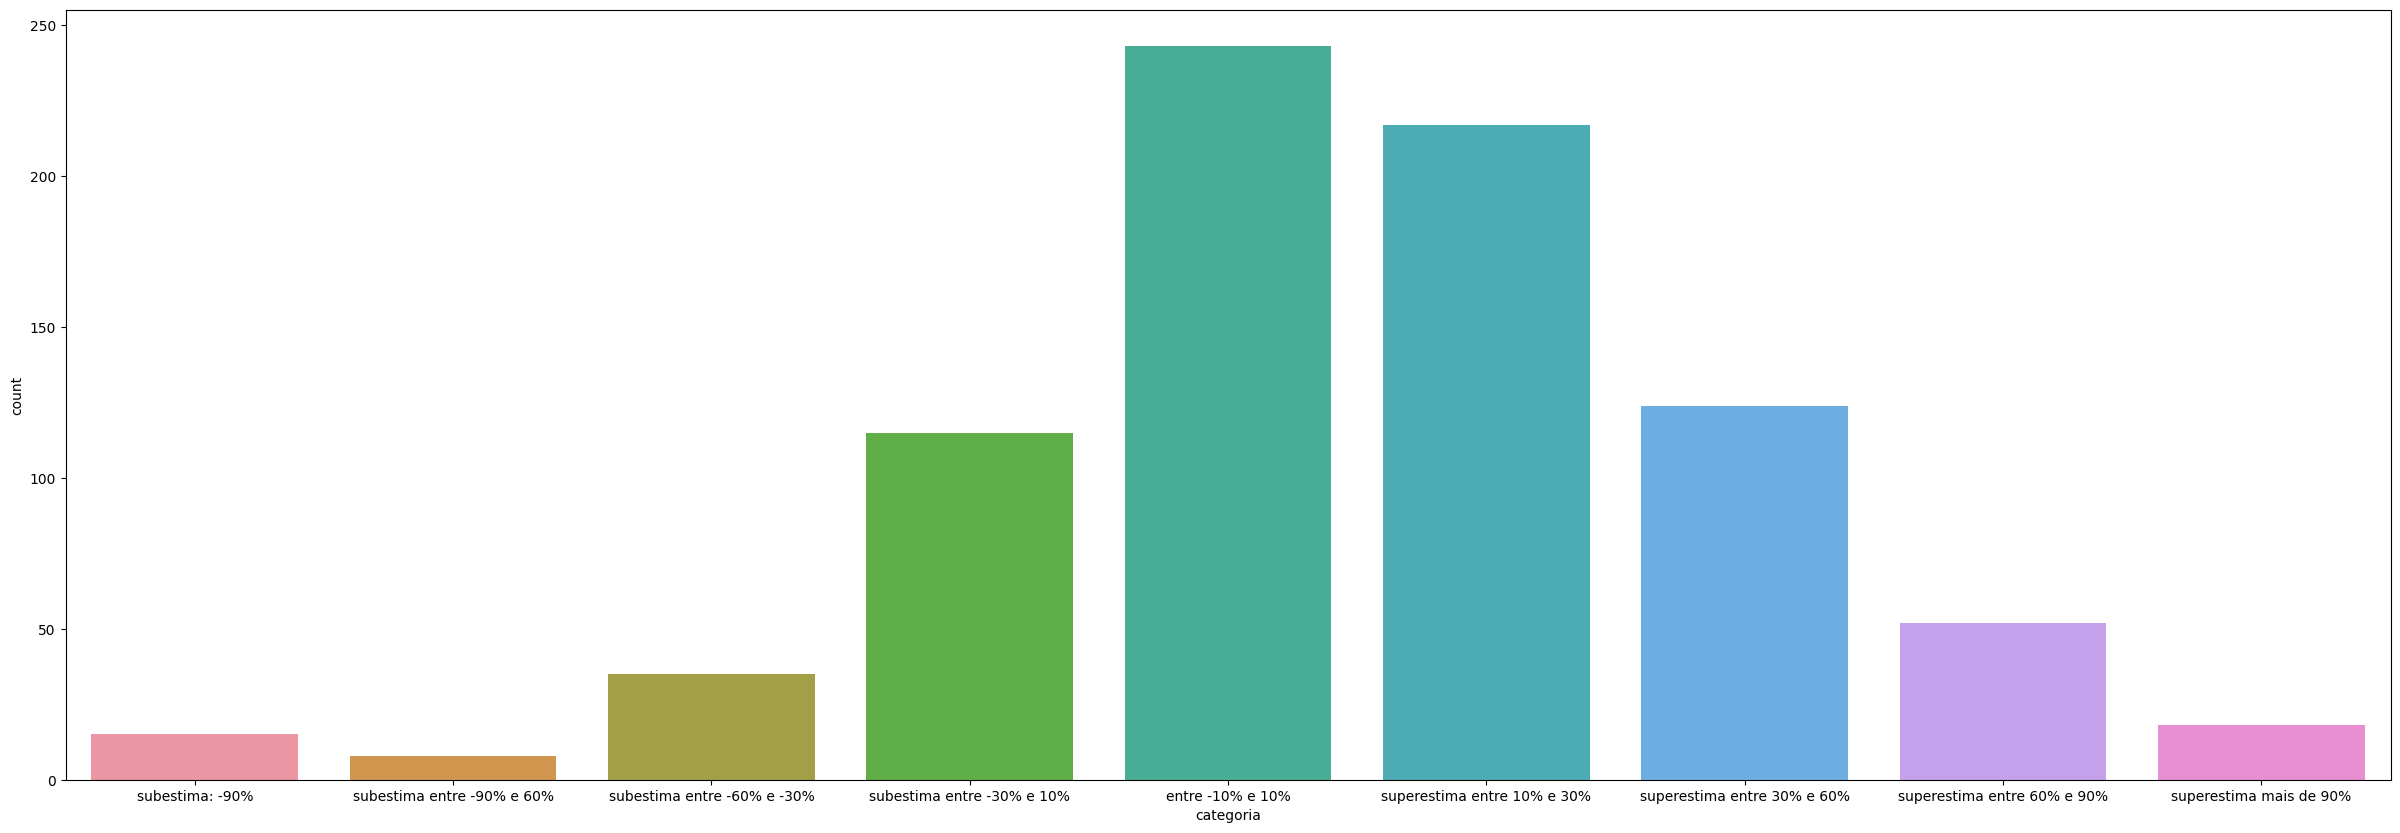

In [65]:
err = show_delta(np.array(y_test), y_pred_mlp.flatten())

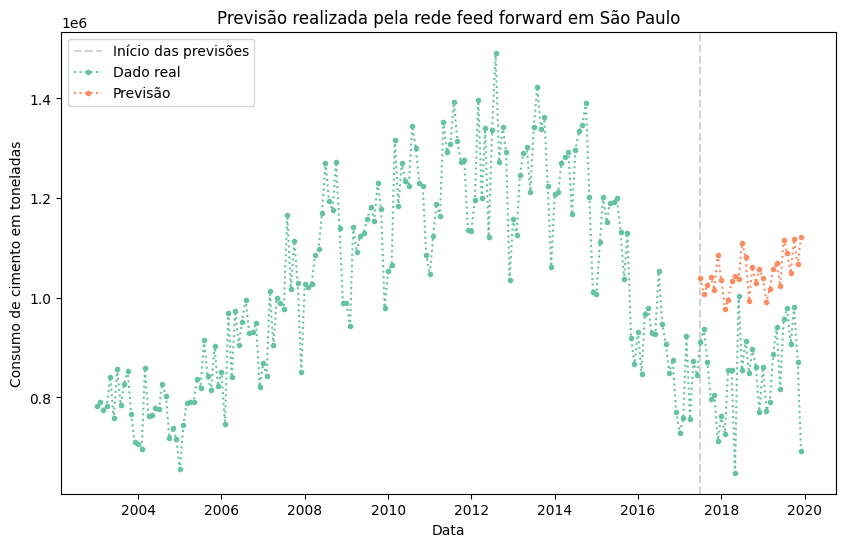

In [66]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pela rede feed forward em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

In [67]:
err.to_csv("../experimentos/erro-mlp.csv", index=False)

In [24]:
y_pred_mlp.tofile("prev_mlp.csv", sep=",", format="%10.3f")

In [25]:
prev = pd.DataFrame(y_pred_mlp, columns=["y_prev_mlp"])

In [42]:
prev.to_csv("../experimentos/prev_mlp.csv", index=False)

,y_prev_mlp
0,414211.593750
1,74905.078125
2,95286.906250
3,127755.070312
4,83529.367188
5,160261.828125
6,68782.273438
7,349117.937500
8,212910.218750
9,64996.175781


# LSTM

In [57]:
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y

df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(StandardScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=150, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 19659.6269880272
MAE: 10352.500194307762
MAPE: 0.10461414551711014
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43918.041892140835
MAE: 22694.21580847538
MAPE: 0.18903688698380017


In [58]:
pred=get_pred(y_test, y_pred)
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data') 

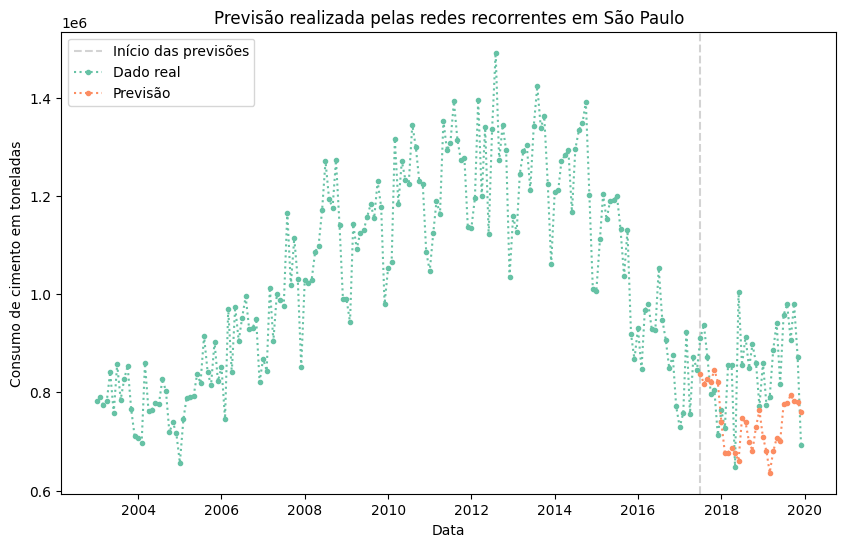

In [60]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelas redes recorrentes em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

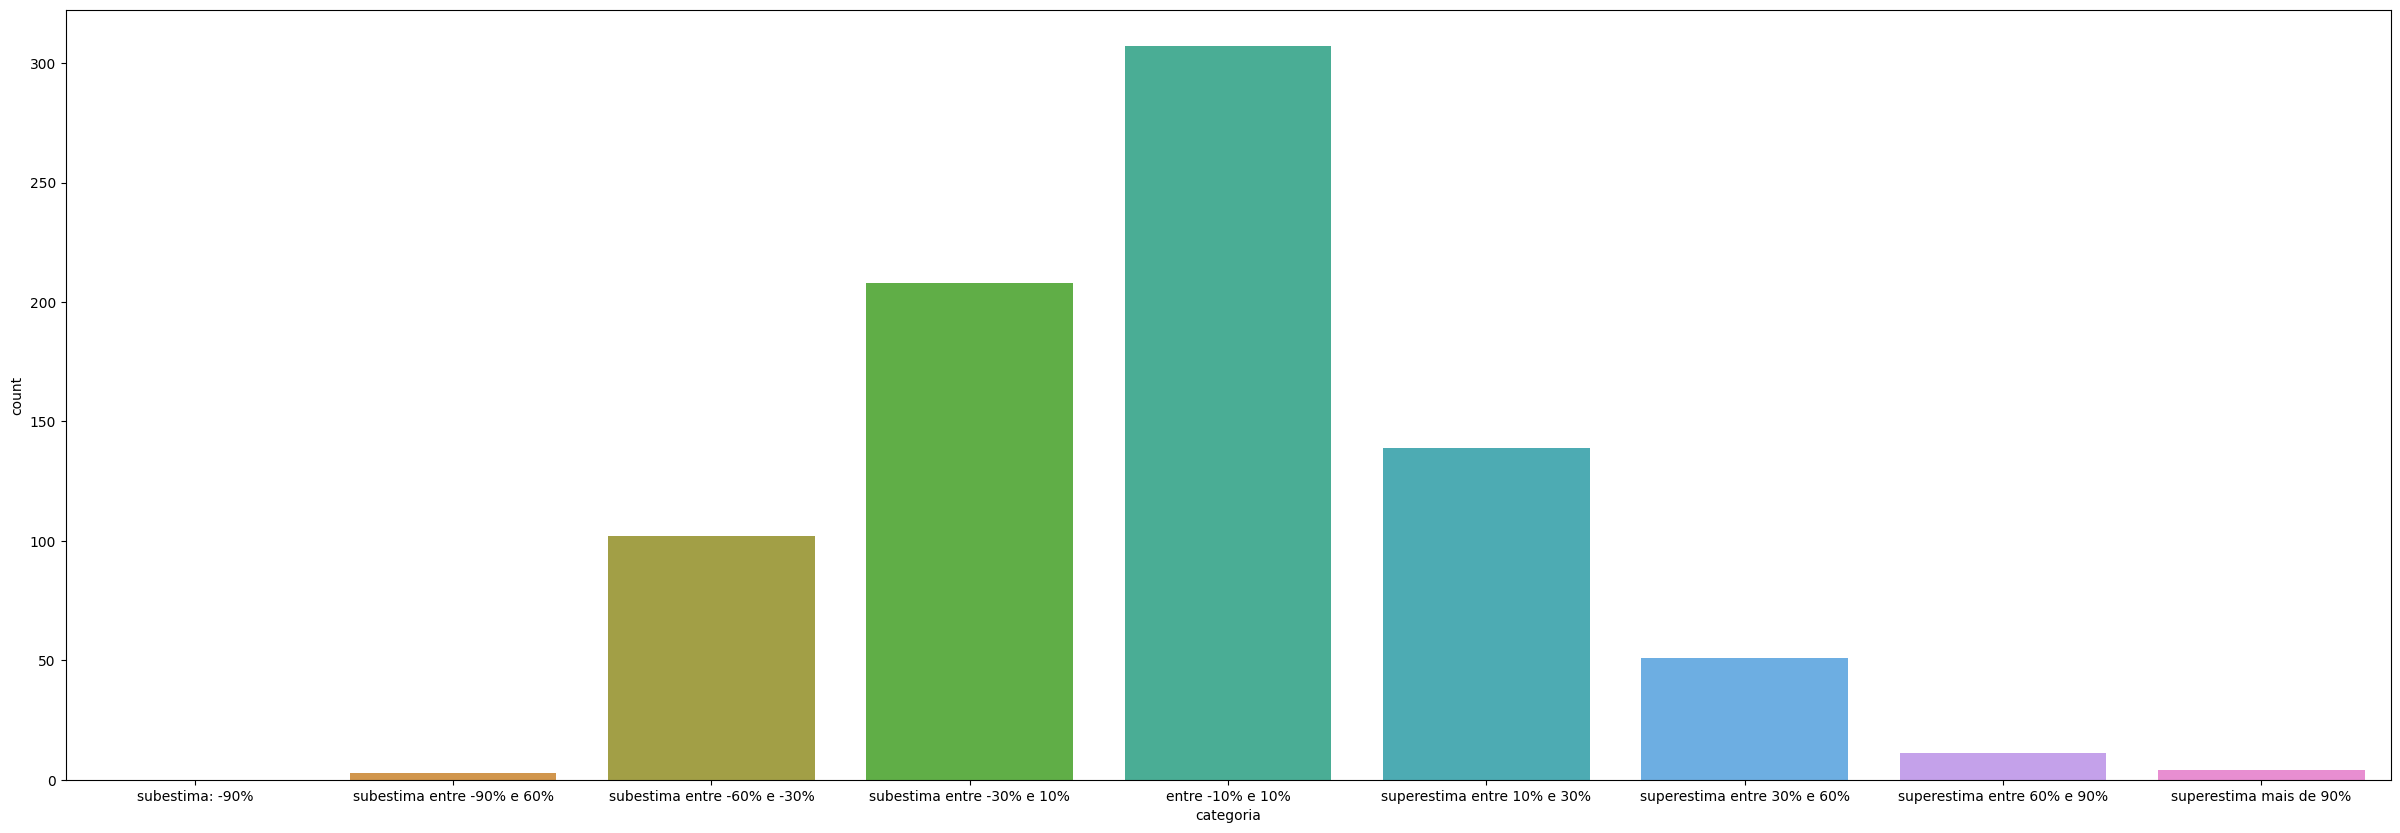

In [62]:
err = show_delta(np.array(y_test), y_pred.flatten())
err.to_csv("../experimentos/erro-rnn.csv", index=False)

In [52]:
pd.DataFrame(y_pred, columns=["y_pred_lstm"]).to_csv("prev_lstm.csv", index=False)

# Bidirection

In [53]:
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y

df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(LSTM(units=32, activation="relu"))),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=150, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 23190.663128416305
MAE: 12615.254439958208
MAPE: 0.11307345986738139
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 35571.02327611449
MAE: 20335.500911458334
MAPE: 0.1984885840875183


In [68]:
set_seeds(41)

x,y = load_data()

timestep=5

df = x.copy()
df["consumo"] = y

df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(LSTM(units=32, activation="relu"))),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=150, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 24532.616735806
MAE: 13254.403195458242
MAPE: 0.12698784677871916
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 35813.69774993322
MAE: 20209.59754293078
MAPE: 0.17496338942238973


In [69]:
pred=get_pred(y_test, y_pred)
df = pd.read_csv(f"{PATH}df.csv")
pred = pred.reset_index()
df=df[["data","estados", "consumo"]]
pred['data'] = pd.to_datetime(pred['data'])
df['data'] = pd.to_datetime(df['data'])
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)
resultados=resultados.set_index('data') 

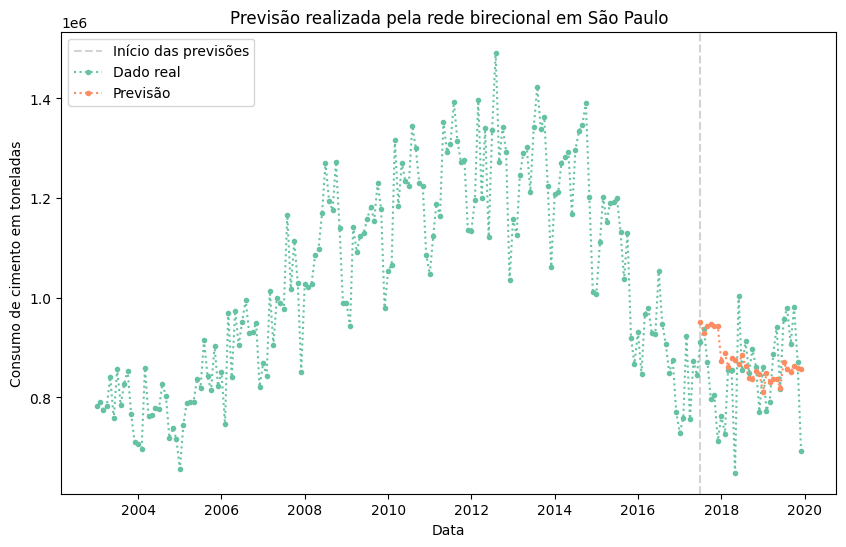

In [71]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pela rede birecional em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()

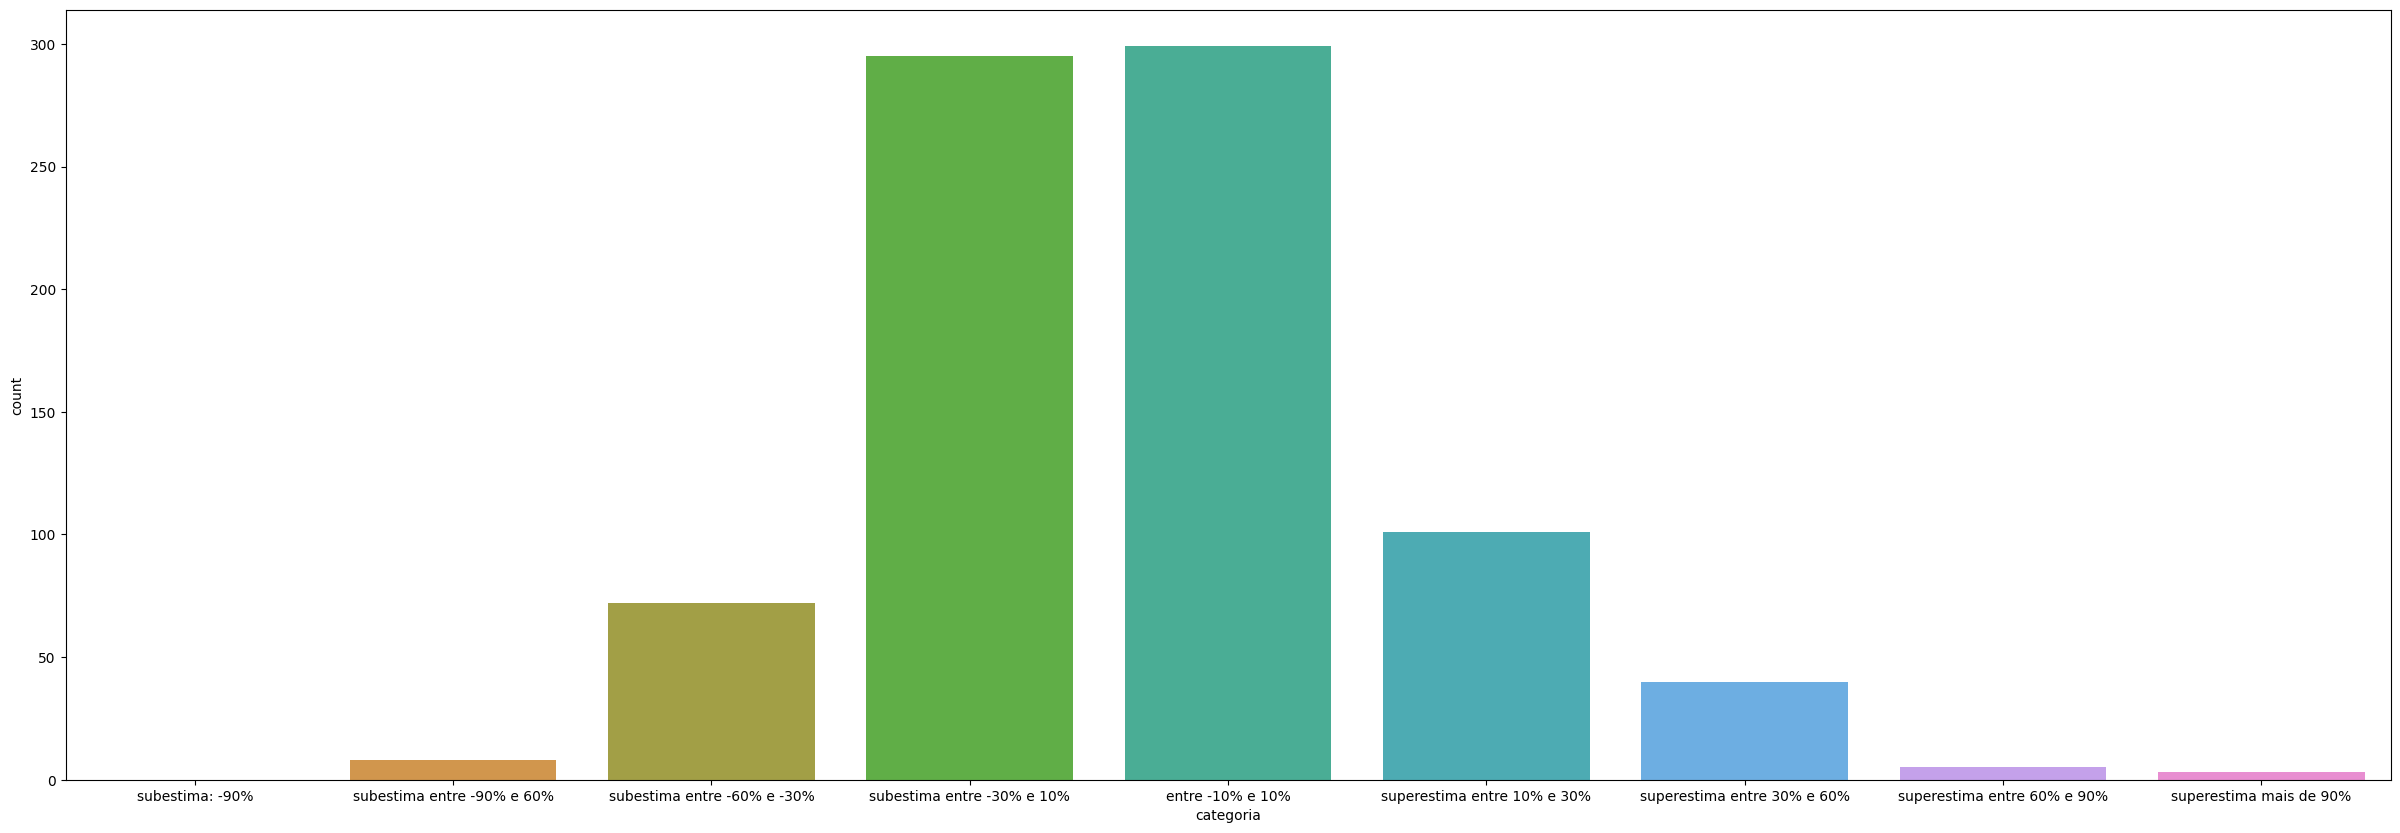

In [72]:
err = show_delta(np.array(y_test), y_pred.flatten())
err.to_csv("../experimentos/erro-bi.csv", index=False)

In [16]:
df[-324

In [17]:
['consumo'].mean()

157867.50048783587

In [23]:
df.head()

,estados,data,pib_pc,pib_pmc,pib_pcpt,pib_cc,populacao,incc,ipca,igp,...,idh_r,idh_e,nfsp,estoque,desemprego,producao,preco_ton,preco_saco,preco_kg,consumo
0,AC,2003-01-01,4.342234e+05,2.285692e+05,0.739806,5.065002e+05,586942.0,1.7,12.53,2.7,...,0.612,0.325,3.46,6.098524e+06,6.582788,-1.0,-1.000000,-1.0,-1.00,3260.0
204,AL,2003-01-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.7,12.53,2.7,...,0.574,0.282,3.46,6.098524e+06,9.080515,-1.0,85.496015,15.5,0.31,30109.0
408,AM,2003-01-01,2.883869e+06,1.518029e+06,0.973688,2.401570e+06,2961801.0,1.7,12.53,2.7,...,0.608,0.324,3.46,6.098524e+06,12.966133,-1.0,107.559502,19.5,0.39,28193.0
612,AP,2003-01-01,4.708095e+05,2.478276e+05,0.911519,3.136418e+05,516511.0,1.7,12.53,2.7,...,0.638,0.424,3.46,6.098524e+06,20.539464,-1.0,-1.000000,-1.0,-1.00,10392.0
816,BA,2003-01-01,7.990762e+06,4.206227e+06,0.599762,7.050330e+06,13323212.0,1.7,12.53,2.7,...,0.594,0.332,3.46,6.098524e+06,10.735432,-1.0,85.496015,15.5,0.31,151297.0


In [45]:
df[(df['estados'] == "MG") & (df['data'] >= '2019')]['consumo'].sum()

6256450.0

In [46]:
df[df['data'] >= '2019']['consumo'].sum()

48995594.0

In [37]:
10458276/48995594

0.21345339746263714

In [40]:
10001077/46032636

0.21726057573587573

In [47]:
6256450.0/48995594.0

0.1276941351093733

In [48]:
0.127 +0.086

0.213

In [13]:
x,y= load_data()

In [18]:
df = pd.read_csv(f"{PATH}df.csv")

In [19]:
df['consumo'].mean()

157867.50048783587

In [20]:
df[df['data'] >= '2019']['consumo'].mean()

151220.96913580247

In [17]:
df.head()

,pib_pc,pib_pmc,pib_pcpt,pib_cc,populacao,incc,ipca,igp,selic,idh_l,...,estados_RJ,estados_RN,estados_RO,estados_RR,estados_RS,estados_SC,estados_SE,estados_SP,estados_TO,consumo
0,4.342234e+05,2.285692e+05,0.739806,5.065002e+05,586942.0,1.7,12.53,2.7,0.082293,0.694,...,0,0,0,0,0,0,0,0,0,3260.0
204,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.7,12.53,2.7,0.082293,0.647,...,0,0,0,0,0,0,0,0,0,30109.0
408,2.883869e+06,1.518029e+06,0.973688,2.401570e+06,2961801.0,1.7,12.53,2.7,0.082293,0.692,...,0,0,0,0,0,0,0,0,0,28193.0
612,4.708095e+05,2.478276e+05,0.911519,3.136418e+05,516511.0,1.7,12.53,2.7,0.082293,0.711,...,0,0,0,0,0,0,0,0,0,10392.0
816,7.990762e+06,4.206227e+06,0.599762,7.050330e+06,13323212.0,1.7,12.53,2.7,0.082293,0.680,...,0,0,0,0,0,0,0,0,0,151297.0
